In [9]:
import os
import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
from os import getcwd

  sets=[('2007', 'train'), ('2007', 'val')]
  classes = ["kangaroo", "raccoon"]

  # 把 annotation 轉換訓練時需要的資料形態
  def convert_annotation(year, image_id, list_file):
      in_file = open('VOC%s/Annotations/%s.xml'%(year, image_id))
      tree=ET.parse(in_file)
      root = tree.getroot()
      for obj in root.iter('object'):
          difficult = obj.find('difficult').text
          cls = obj.find('name').text
          if cls not in classes or int(difficult)==1:
              continue
          cls_id = classes.index(cls)
          xmlbox = obj.find('bndbox')
          b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
          list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

  wd = "."

  for year, image_set in sets:
      image_ids = open('VOC%s/ImageSets/Main/%s.txt'%(year, image_set)).read().strip().split()
      annotation_path = '%s_%s.txt'%(year, image_set)
      list_file = open(annotation_path, 'w')
      print("save annotation at %s" % annotation_path)
      for image_id in image_ids[:100]:
          list_file.write('%s/VOC%s/JPEGImages/%s.jpg'%(wd, year, image_id))
          convert_annotation(year, image_id, list_file)
          list_file.write('\n')
      list_file.close()

In [10]:
# 將 train.py 所需要的套件載入
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth =True

In [5]:
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

In [7]:
annotation_path = '2007_train.txt' # 轉換好格式的標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights_class2.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 4
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 1 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')

Create YOLOv3 model with 9 anchors and 2 classes.
Load weights model_data/yolo_weights_class2.h5.
Freeze the first 249 layers of total 252 layers.
Train on 266 samples, val on 29 samples, with batch size 4.
Epoch 1/50
66/66 [==============================] - 21s 316ms/step - loss: 5726.2138 - val_loss: nan
Epoch 2/50
66/66 [==============================] - 19s 284ms/step - loss: 3937.5367 - val_loss: nan
Epoch 3/50
66/66 [==============================] - 19s 286ms/step - loss: 2817.3328 - val_loss: nan
Epoch 4/50


C:\Users\d211\Anaconda3\envs\python3.6\lib\site-packages\keras\callbacks.py:436: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


66/66 [==============================] - 19s 288ms/step - loss: 2099.2855 - val_loss: nan
Epoch 5/50
66/66 [==============================] - 19s 286ms/step - loss: 1620.6628 - val_loss: nan
Epoch 6/50
66/66 [==============================] - 19s 289ms/step - loss: 1289.5221 - val_loss: nan
Epoch 7/50
66/66 [==============================] - 19s 290ms/step - loss: 1052.0128 - val_loss: nan
Epoch 8/50
66/66 [==============================] - 19s 286ms/step - loss: 875.6534 - val_loss: nan
Epoch 9/50
66/66 [==============================] - 19s 290ms/step - loss: 741.9650 - val_loss: nan
Epoch 10/50
66/66 [==============================] - 19s 285ms/step - loss: 637.5067 - val_loss: nan
Epoch 11/50
66/66 [==============================] - 19s 284ms/step - loss: 554.5223 - val_loss: nan
Epoch 12/50
66/66 [==============================] - 19s 284ms/step - loss: 487.7063 - val_loss: nan
Epoch 13/50
66/66 [==============================] - 19s 283ms/step - loss: 432.6655 - val_loss: nan
Epo

266/266 [==============================] - 119s 449ms/step - loss: 18.1583 - val_loss: 21.6907
Epoch 80/100
266/266 [==============================] - 119s 449ms/step - loss: 17.9378 - val_loss: 22.4432

Epoch 00080: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.
Epoch 81/100
266/266 [==============================] - 120s 451ms/step - loss: 20.4461 - val_loss: 22.6352
Epoch 00081: early stopping


In [12]:
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
image = Image.open('test2.jpg') 

In [13]:
from yolo import YOLO
yolo_model = YOLO(model_path='trained_weights_final.h5', 
                  classes_path='model_data/classes.txt')


trained_weights_final.h5 model, anchors, and classes loaded.


In [14]:
r_image = yolo_model.detect_image(image)

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.53 (45, 18) (261, 152)
kangaroo 0.74 (334, 352) (598, 604)
1.6470876374061731


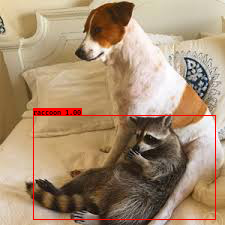

In [22]:
r_image

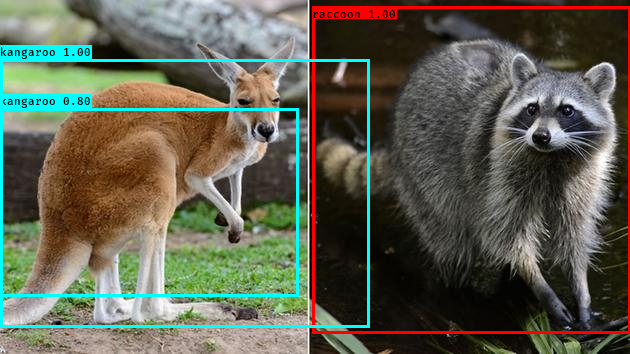

In [11]:
r_image

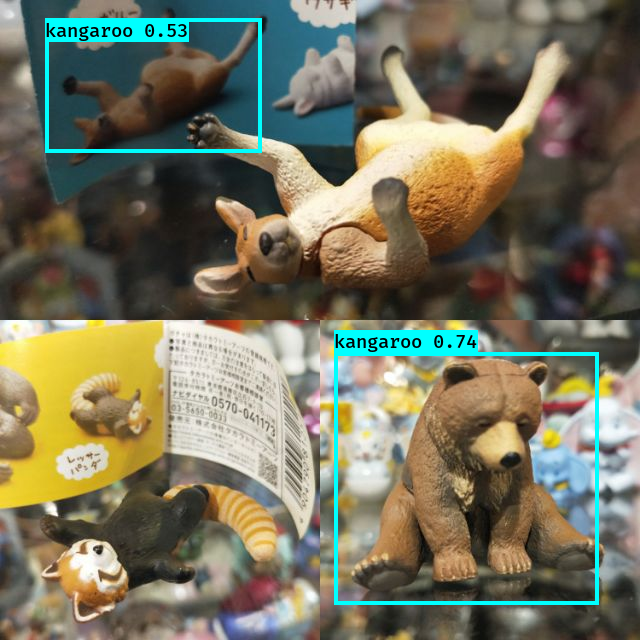

In [15]:
r_image

In [1]:
%run yolo_video.py --model trained_weights_final.h5 --classes classes.txt --input raccoon.mp4 --output Result_raccoon.avi

Using TensorFlow backend.
C:\Users\d211\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\d211\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\d211\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\d211\AppData\Roaming








trained_weights_final.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
!!! TYPE: <class 'str'> <class 'int'> <class 'float'> <class 'tuple'>
(416, 416, 3)
Found 0 boxes for img
2.595452893190284
(416, 416, 3)
Found 0 boxes for img
0.09763443612905487
(416, 416, 3)
Found 0 boxes for img
0.10162321866518598
(416, 416, 3)
Found 0 boxes for img
0.09567592367868993
(416, 416, 3)
Found 0 boxes for img
0.09547478065436321
(416, 416, 3)
Found 0 boxes for img
0.09688001125957646
(416, 416, 3)
Found 0 boxes for img
0.09677639212583244
(416, 416, 3)
Found 0 boxes for img
0.09665698077117035
(416, 416, 3)
Found 0 boxes for img
0.09822401237666822
(416, 416, 3)
Found 0 boxes for img
0.0951506245407785
(416, 416, 3)
Found 0 boxes for img
0.09688278182464982
(416, 416, 3)
Found 0 boxes for img
0.09936520813038952
(416, 416, 3)
Found 0 boxes for img
0.09687973420306895
(416, 416, 3)
Found 0 boxes for img
0.09491

Found 0 boxes for img
0.09775661804879121
(416, 416, 3)
Found 0 boxes for img
0.0953761485377509
(416, 416, 3)
Found 0 boxes for img
0.09775384748371785
(416, 416, 3)
Found 0 boxes for img
0.09654560405522083
(416, 416, 3)
Found 0 boxes for img
0.09854872260326886
(416, 416, 3)
Found 0 boxes for img
0.10047869823337763
(416, 416, 3)
Found 0 boxes for img
0.09846283508599285
(416, 416, 3)
Found 0 boxes for img
0.09650681614419376
(416, 416, 3)
Found 0 boxes for img
0.09954945070776766
(416, 416, 3)
Found 0 boxes for img
0.10414277054290899
(416, 416, 3)
Found 0 boxes for img
0.09722439249819814
(416, 416, 3)
Found 0 boxes for img
0.09952673207416751
(416, 416, 3)
Found 0 boxes for img
0.09878283535196886
(416, 416, 3)
Found 0 boxes for img
0.09565431327111895
(416, 416, 3)
Found 0 boxes for img
0.09885043713975605
(416, 416, 3)
Found 0 boxes for img
0.0972961501335945
(416, 416, 3)
Found 0 boxes for img
0.09676641809156905
(416, 416, 3)
Found 0 boxes for img
0.09762086036019468
(416, 41

Found 0 boxes for img
0.10038754664246596
(416, 416, 3)
Found 0 boxes for img
0.0982508868578762
(416, 416, 3)
Found 0 boxes for img
0.09905573601169237
(416, 416, 3)
Found 0 boxes for img
0.09792673074429814
(416, 416, 3)
Found 0 boxes for img
0.10008749444501319
(416, 416, 3)
Found 0 boxes for img
0.09830158819872281
(416, 416, 3)
Found 0 boxes for img
0.09970626469092281
(416, 416, 3)
Found 0 boxes for img
0.10047038653815576
(416, 416, 3)
Found 0 boxes for img
0.10168167758823188
(416, 416, 3)
Found 0 boxes for img
0.09929511283403514
(416, 416, 3)
Found 0 boxes for img
0.09723104185437137
(416, 416, 3)
Found 0 boxes for img
0.10151101077971703
(416, 416, 3)
Found 0 boxes for img
0.10025206601037695
(416, 416, 3)
Found 0 boxes for img
0.09699305031457328
(416, 416, 3)
Found 0 boxes for img
0.09960624729176715
(416, 416, 3)
Found 0 boxes for img
0.09878505180402186
(416, 416, 3)
Found 0 boxes for img
0.09780925878518332
(416, 416, 3)
Found 0 boxes for img
0.09958934684482301
(416, 4

Found 0 boxes for img
0.09420863241582822
(416, 416, 3)
Found 0 boxes for img
0.09581528310187792
(416, 416, 3)
Found 0 boxes for img
0.09543848625190066
(416, 416, 3)
Found 0 boxes for img
0.09434023425681914
(416, 416, 3)
Found 0 boxes for img
0.09594716199936926
(416, 416, 3)
Found 0 boxes for img
0.09517666785247059
(416, 416, 3)
Found 0 boxes for img
0.09660461709128754
(416, 416, 3)
Found 0 boxes for img
0.09441587068332069
(416, 416, 3)
Found 0 boxes for img
0.0943069874759388
(416, 416, 3)
Found 0 boxes for img
0.1018213140679336
(416, 416, 3)
Found 0 boxes for img
0.09912333779948312
(416, 416, 3)
Found 0 boxes for img
0.09559557729156154
(416, 416, 3)
Found 0 boxes for img
0.09598373345833977
(416, 416, 3)
Found 0 boxes for img
0.09443803520390759
(416, 416, 3)
Found 0 boxes for img
0.09465330811011086
(416, 416, 3)
Found 0 boxes for img
0.09422193112818178
(416, 416, 3)
Found 0 boxes for img
0.09604246943789718
(416, 416, 3)
Found 0 boxes for img
0.09526089303069796
(416, 41